In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
import joblib

In [10]:
df = pd.read_csv(r"C:\Users\ASUS\Downloads\telecom_churn.csv")
print("✅ Dataset loaded successfully!")
print(df.head())

print("\nDataset shape:", df.shape)
print("\nMissing values per column:\n", df.isna().sum())

✅ Dataset loaded successfully!
   Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1        2.7              1   
1      0           107                1         1        3.7              1   
2      0           137                1         0        0.0              0   
3      0            84                0         0        0.0              2   
4      0            75                0         0        0.0              3   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  
3    299.4        71           57.0        3.10       6.6  
4    166.7       113           41.0        7.42      10.1  

Dataset shape: (3333, 11)

Missing values per column:
 Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan       

In [12]:
target_col = "Churn"
df = df[df[target_col].notna()].reset_index(drop=True)
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
print("\nTarget distribution:\n", df[target_col].value_counts())


Target distribution:
 Churn
0    2850
1     483
Name: count, dtype: int64


In [14]:
X = df.drop(columns=[target_col])
y = df[target_col]
id_like = [c for c in X.columns if "id" in c.lower() or X[c].nunique() == len(X)]
X = X.drop(columns=id_like, errors='ignore')

In [16]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()
print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins']
Categorical features: []


In [20]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (2666, 10)
Test set size: (667, 10)


In [22]:
log_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced"))
])

print("\nTraining Logistic Regression...")
log_model.fit(X_train, y_train)
print("Training Random Forest...")
rf_model.fit(X_train, y_train)


Training Logistic Regression...
Training Random Forest...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AccountWeeks',
                                                   'ContractRenewal',
                                                   'DataPlan', 'DataUsage',
                                                   'CustServCalls', 'DayMins',
                                                   'DayCalls', 'MonthlyCharge',
                                                   'OverageFee', 'RoamMins']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [24]:
def evaluate_model(model, X_test, y_test, name="model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== {name} Performance ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("ROC AUC:", roc)
    print("Confusion Matrix:\n", cm)
    return {"f1": f1, "roc_auc": roc, "model": model}

In [26]:
log_results = evaluate_model(log_model, X_test, y_test, "Logistic Regression")
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")

best = rf_results if rf_results["f1"] > log_results["f1"] else log_results
best_model = best["model"]
print("\n🏆 Selected best model:", "Random Forest" if best is rf_results else "Logistic Regression")


=== Logistic Regression Performance ===
Accuracy: 0.760119940029985
Precision: 0.34782608695652173
Recall: 0.7422680412371134
F1 Score: 0.47368421052631576
ROC AUC: 0.8094953879544221
Confusion Matrix:
 [[435 135]
 [ 25  72]]

=== Random Forest Performance ===
Accuracy: 0.9265367316341829
Precision: 0.8333333333333334
Recall: 0.6185567010309279
F1 Score: 0.7100591715976331
ROC AUC: 0.8605444022427202
Confusion Matrix:
 [[558  12]
 [ 37  60]]

🏆 Selected best model: Random Forest


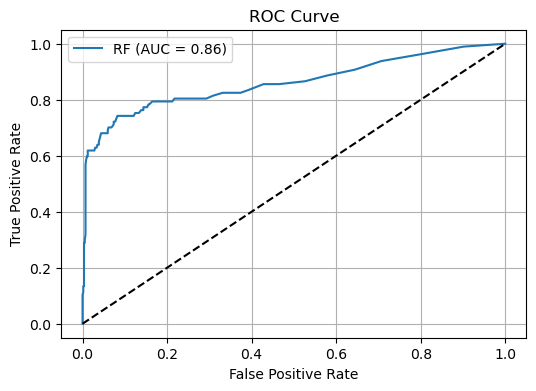


✅ Model saved as churn_model.pkl


In [28]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"{'RF' if best is rf_results else 'LR'} (AUC = {best['roc_auc']:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

joblib.dump(best_model, "churn_model.pkl")
print("\n✅ Model saved as churn_model.pkl")